# How to simulate multiple virus strains

In this tutorial, we are going to simulate the spread of Covid-19 with two virus strains.

In [1]:
%matplotlib inline

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sid
from sid.config import INDEX_NAMES

warnings.filterwarnings(
    "ignore", message="indexing past lexsort depth may impact performance."
)

## Preparation

For the simulation we need to prepare several objects which are identical to the ones from the general tutorial on the [simulation](how_to_simulate.ipynb).

In [2]:
available_ages = [
    "0-9",
    "10-19",
    "20-29",
    "30-39",
    "40-49",
    "50-59",
    "60-69",
    "70-79",
    "80-100",
]

ages = np.random.choice(available_ages, size=10_000)
regions = np.random.choice(["North", "South"], size=10_000)

initial_states = pd.DataFrame({"age_group": ages, "region": regions}).astype("category")
initial_states.head(5)

,age_group,region
0,60-69,South
1,50-59,South
2,70-79,North
3,70-79,North
4,10-19,North


In [3]:
def meet_distant(states, params, seed):
    possible_nr_contacts = np.arange(10)
    contacts = np.random.choice(possible_nr_contacts, size=len(states))
    return pd.Series(contacts, index=states.index)


def meet_close(states, params, seed):
    possible_nr_contacts = np.arange(5)
    contacts = np.random.choice(possible_nr_contacts, size=len(states))
    return pd.Series(contacts, index=states.index)


assort_by = ["age_group", "region"]

contact_models = {
    "distant": {"model": meet_distant, "assort_by": assort_by, "is_recurrent": False},
    "close": {"model": meet_close, "assort_by": assort_by, "is_recurrent": False},
}

In [4]:
epidemiological_parameters = pd.read_csv("infection_probs.csv", index_col=INDEX_NAMES)
epidemiological_parameters

value  note  source
category       subcategory name                          
infection_prob close       close       0.05   NaN     NaN
               distant     distant     0.03   NaN     NaN
               household   household   0.20   NaN     NaN

In [5]:
assort_probs = pd.read_csv("assort_by_params.csv", index_col=INDEX_NAMES)
assort_probs

value  note  source
category             subcategory name                          
assortative_matching close       age_group    0.5   NaN     NaN
                                 region       0.9   NaN     NaN
                     distant     age_group    0.5   NaN     NaN
                                 region       0.9   NaN     NaN

In [6]:
disease_params = sid.load_epidemiological_parameters()
disease_params.head(6).round(2)

value
category           subcategory        name                     
health_system      icu_limit_relative icu_limit_relative  50.00
cd_immune_false    all                365                  1.00
cd_infectious_true all                1                    0.39
                                      2                    0.35
                                      3                    0.22
                                      5                    0.04

In [7]:
params = pd.concat([disease_params, epidemiological_parameters, assort_probs])

In [8]:
def contact_policy_is_active(states):
    return states["infectious"].mean() > 0.1


contact_policies = {
    "policy_close_contacts": {
        "start": "2020-03-12",
        "policy": 0.5,
        "is_active": contact_policy_is_active,
        "affected_contact_model": "close",
    },
    "policy_distant_contacts": {
        "start": "2020-03-12",
        "policy": 0.5,
        "is_active": contact_policy_is_active,
        "affected_contact_model": "distant",
    },
}

## Additional objects to simulate multiple virus strains

To implement multiple virus strains, we have to make the following extensions to the model.

1. Add a multiplier for the contagiousness of each virus to the parameters.
2. Prepare a DataFrame for the initial conditions.

In [9]:
for virus, multiplier in [("base", 1), ("b117", 1.3)]:
    params.loc[("virus_strain", virus, "factor"), "value"] = multiplier

For the initial conditions, we assume a two-day burn-in period. On the first day, 50 people are infected with the base virus, on the second day one halve of 50 people has the old and the other halve the new variant.

Each column in the DataFrame is a categorical. Infected individuals have a code for the variant, all others have NaNs.

In [10]:
infected_first_day = set(np.random.choice(10_000, size=50, replace=False))
first_day = pd.Series([pd.NA] * 10_000)
first_day.iloc[list(infected_first_day)] = "base"

In [11]:
infected_second_day_old_variant = set(
    np.random.choice(
        list(set(range(10_000)) - infected_first_day), size=25, replace=False
    )
)
infected_second_day_new_variant = set(
    np.random.choice(
        list(set(range(10_000)) - infected_first_day - infected_second_day_old_variant),
        size=25,
        replace=False,
    )
)

second_day = pd.Series([pd.NA] * 10_000)
second_day.iloc[list(infected_second_day_old_variant)] = "base"
second_day.iloc[list(infected_second_day_new_variant)] = "b117"

In [12]:
initial_infections = pd.DataFrame(
    {
        pd.Timestamp("2020-02-25"): pd.Categorical(
            first_day, categories=["base", "b117"]
        ),
        pd.Timestamp("2020-02-26"): pd.Categorical(
            second_day, categories=["base", "b117"]
        ),
    }
)

In [13]:
initial_conditions = {"initial_infections": initial_infections, "initial_immunity": 50}

## Run the simulation

We are going to simulate this population for 200 periods.

In [14]:
simulate = sid.get_simulate_func(
    initial_states=initial_states,
    contact_models=contact_models,
    params=params,
    contact_policies=contact_policies,
    initial_conditions=initial_conditions,
    duration={"start": "2020-02-27", "periods": 365},
    virus_strains=["base", "b117"],
    seed=0,
)
result = simulate(params=params)

Start the simulation...
2021-02-25: 100%|██████████████████████████████████████████████████| 365/365 [00:48<00:00,  7.58it/s]


In [15]:
result["time_series"].head()

,region,virus_strain,dead,age_group,infectious,n_has_infected,immune,ever_vaccinated,date,needs_icu,is_tested_positive_by_rapid_test,new_known_case,newly_infected,cd_infectious_false,newly_deceased,knows_infectious,knows_immune,newly_vaccinated,symptomatic,ever_infected
0,South,NaN,False,60-69,False,0,False,False,2020-02-27,False,False,False,False,-102,False,False,False,False,False,False
1,South,NaN,False,50-59,False,0,False,False,2020-02-27,False,False,False,False,-102,False,False,False,False,False,False
2,North,NaN,False,70-79,False,0,False,False,2020-02-27,False,False,False,False,-102,False,False,False,False,False,False
3,North,NaN,False,70-79,False,0,False,False,2020-02-27,False,False,False,False,-102,False,False,False,False,False,False
4,North,NaN,False,10-19,False,0,False,False,2020-02-27,False,False,False,False,-102,False,False,False,False,False,False


In [16]:
result["last_states"].head()

,index,age_group,region,ever_infected,immune,infectious,symptomatic,needs_icu,dead,pending_test,...,cd_is_immune_by_vaccine_draws,cd_infectious_false_draws,cd_needs_icu_true_draws,cd_needs_icu_false_draws,group_codes_close,group_codes_distant,date,period,n_contacts_close,n_contacts_distant
0,0,60-69,South,False,False,False,False,False,False,False,...,21,11,-1,-1,13,13,2021-02-25,786,1,1
1,1,50-59,South,False,False,False,False,False,False,False,...,21,5,-1,-1,11,11,2021-02-25,786,1,6
2,2,70-79,North,False,False,False,False,False,False,False,...,21,5,-1,45,14,14,2021-02-25,786,4,8
3,3,70-79,North,False,False,False,False,False,False,False,...,14,11,-1,-1,14,14,2021-02-25,786,3,6
4,4,10-19,North,False,False,False,False,False,False,False,...,-1,11,-1,1,2,2,2021-02-25,786,1,4


The return of `simulate` is a dictionary with containing the time series data and the last states as a [Dask DataFrame](https://docs.dask.org/en/latest/dataframe.html). This allows to load the data lazily.

The ``last_states`` can be used to resume the simulation. We will inspect the ``time_series`` data. If data data fits your working memory, do the following to convert it to a pandas DataFrame.

In [17]:
df = result["time_series"].compute()

Let us take a look at various statistics of the sample.

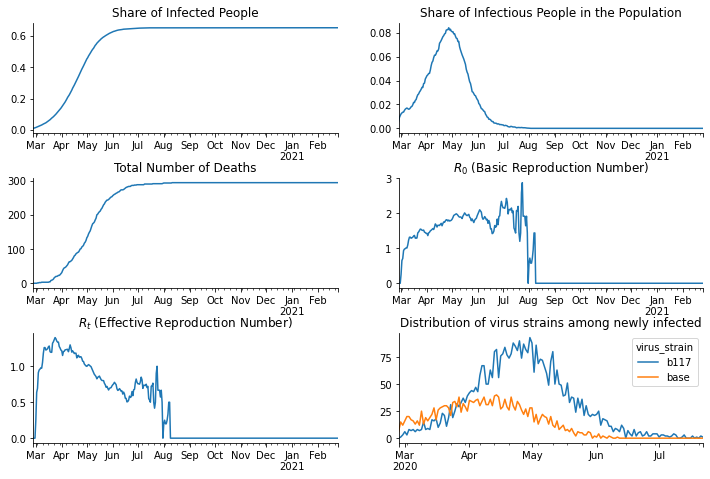

In [18]:
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
fig.subplots_adjust(bottom=0.15, wspace=0.2, hspace=0.4)

axs = axs.flatten()

df.resample("D", on="date")["ever_infected"].mean().plot(ax=axs[0])
df.resample("D", on="date")["infectious"].mean().plot(ax=axs[1])
df.resample("D", on="date")["dead"].sum().plot(ax=axs[2])

r_zero = sid.statistics.calculate_r_zero(df, window_length=7)
r_zero.plot(ax=axs[3])

r_effective = sid.statistics.calculate_r_effective(df, window_length=7)
r_effective.plot(ax=axs[4])

df.query("newly_infected").groupby([pd.Grouper(key="date", freq="D"), "virus_strain"])[
    "newly_infected"
].count().unstack().plot(ax=axs[5])

for ax in axs:
    ax.set_xlabel("")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

axs[0].set_title("Share of Infected People")
axs[1].set_title("Share of Infectious People in the Population")
axs[2].set_title("Total Number of Deaths")
axs[3].set_title("$R_0$ (Basic Reproduction Number)")
axs[4].set_title("$R_t$ (Effective Reproduction Number)")
axs[5].set_title("Distribution of virus strains among newly infected")

plt.show()